# FastAI Kaggle Starter Kit

WNixalo 16:16 22-Jan-2018

Following along with: [this FastAI Kaggle starter kit](https://www.kaggle.com/timolee/fastai-kaggle-starter-kit-lb-0-33/) notebook. This is a copy of the first code-along; this time I'm using the full dataset for training.

## 1. Importing Libraries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import torch

import shutil
import os
# sys.path.append('../repos/fastai/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFilter
from scipy.ndimage import filters

## 1.1 Importing FastAI Libraries

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
torch.cuda.current_device()

0

## 2. Data Prep

In [5]:
train_df = pd.read_json('data/train.json')
train_df['inc_angle'] = pd.to_numeric(train_df['inc_angle'], errors='coerce')

In [6]:
print(train_df.shape)

(1604, 5)


## 2.1 Organizing Folders + Files for the FastAI Library

In [6]:
PATH = 'data/'

### Set file locations

In [7]:
shipPath = 'data/train/ship/'
icePath  = 'data/train/ice/'
shipValid= 'data/valid/ship/'
iceValid = 'data/valid/ice/'
testPath = 'data/test/'

### Clean up existing folders (drop all files)

Clears out the folders so that files aren't double generated

In [8]:
if not os.path.exists('data/train/'):
    os.mkdir('data/train/')
    os.mkdir(shipPath)
    os.mkdir(icePath)
if not os.path.exists('data/valid/'):
    os.mkdir('data/valid/')
    os.mkdir(shipValid)
    os.mkdir(iceValid)
if not os.path.exists('data/test/'):
    os.mkdir('data/test/')

shutil.rmtree(shipPath)
os.mkdir(shipPath)

shutil.rmtree(icePath)
os.mkdir(icePath)

shutil.rmtree(shipValid)
os.mkdir(shipValid)

shutil.rmtree(iceValid)
os.mkdir(iceValid)

shutil.rmtree(testPath)
os.mkdir(testPath)

os.makedirs('tmp', exist_ok=True)

## 2.2 Image Creation (to Jpegs)

### Creating training dataset in `train/iceberg` and `train/ship`

#### Load Input Json

In [10]:
train_df.shape

(1604, 5)

In [9]:
icebergs = train_df[train_df.is_iceberg==1]
ships    = train_df[train_df.is_iceberg==0]

#### Pull out the different Bands

pictures to increase the dataset size. Some further development of combining the two matrices is possible

https://www.kaggle.com/keremt/getting-color-composites

In [10]:
def color_composite(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75,75)
        band_2 = np.array(row['band_2']).reshape(75,75)
        band_z = band_1 / band_2
        
        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_z + abs(band_z.min())) / np.max((band_z + abs(band_z.min())))
        
        rgb = np.dstack((r,g,b))
        rgb_arrays.append(rgb)
    
    return np.array(rgb_arrays)

In [11]:
iceberg_imgs = color_composite(icebergs)
ship_imgs    = color_composite(ships)

In [12]:
iceberg_imgs.shape

(753, 75, 75, 3)

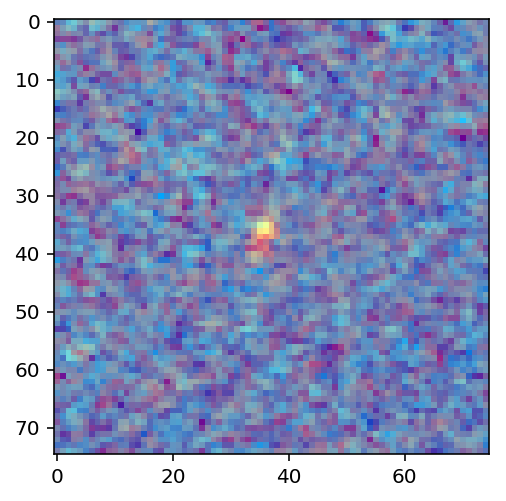

In [13]:
plt.imshow(iceberg_imgs[0])

#### Functions to save to disk

These two functions turn the long raveled vectors into matrices, and then save them to `.png` files with matplotlib.

In [14]:
import matplotlib

def vec2Mat(vec):
    return np.reshape(np.array(vec),(75,75))

def saveMat(array, filename):
    matplotlib.image.imsave(filename, array)

#### Saving each training set to `.png` to its respective folder

Loops through all different datasets and saves them to disk

In [15]:
for i,x in enumerate(iceberg_imgs):
    matplotlib.image.imsave(f'data/train/ice/ice_{i}.png', x)

In [16]:
for i,x in enumerate(ship_imgs):
    matplotlib.image.imsave(f'data/train/ship/ship_{i}.png', x)

#### Creating the testset files in the `test` directory

In [17]:
test_df = pd.read_json('data/test.json')

In [18]:
test_df.head()

,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",4371c8c3,43.918874


In [19]:
test_imgs = color_composite(test_df)

#### Saving the test `.png` files to disk

In [22]:
len(test_imgs)

8424

In [20]:
for i,x in zip(test_df['id'], test_imgs):
    matplotlib.image.imsave(f'data/test/im_{i}.png', x)

#### Memory Cleanup

(will work off files on disk, and delete variables in RAM)

In [21]:
del train_df, test_df, iceberg_imgs, ship_imgs, icebergs, ships, test_imgs

#### Image Processing (adding blur)

In [22]:
icebergs = os.listdir('data/train/ice/')
ships    = os.listdir('data/train/ship/')
test     = os.listdir('data/test/')

In [23]:
for x in icebergs:
    pp = Image.open('data/train/ice/' + x)
    pp = pp.filter(ImageFilter.MedianFilter(5))
    pp = pp.filter(ImageFilter.SHARPEN)
    pp.save('data/train/ice/' + x)
print('processing icebergs')

for x in ships:
    pp = Image.open('data/train/ship/' + x)
    pp = pp.filter(ImageFilter.MedianFilter(5))
    pp = pp.filter(ImageFilter.SHARPEN)
    pp.save('data/train/ship/' + x)
print('processing ships')

for x in test:
    pp = Image.open('data/test/' + x)
    pp = pp.filter(ImageFilter.MedianFilter(5))
    pp = pp.filter(ImageFilter.SHARPEN)
    pp = pp.save('data/test/' + x)
print('processing test set')

processing icebergs
processing ships
processing test set


### 2.2 Create a Validation Set

In [24]:
# get list of directory
ship = os.listdir(shipPath)
ice  = os.listdir(icePath)

# check num files
print(len(ship), len(ice))

sample_ice = np.random.choice(ice, size=1)
sample_ice = list(set(sample_ice))
sample_ship= np.random.choice(ship, size=1)
sample_ship= list(set(sample_ship))

851 753


#### Move files from training to test folder

In [26]:
for x in sample_ice:
    shutil.move(icePath + x, iceValid + x)

for x in sample_ship:
    shutil.move(shipPath + x, shipValid + x)

#### Check training files moved to validation

In [27]:
ship = os.listdir(shipPath)
ice  = os.listdir(icePath)

# check num files
print(len(ship), len(ice))

850 752


#### Check size test set

In [28]:
len(os.listdir(testPath))

8424

## 3. Try a basic `fastai` CNN

`ImageClassifierData` is an instance that looks at the folder structure and takes care of labeling and grouping between the training, validation, and test sets.

`test_name` = be sure to put the name of your test folder here. It doesn't have to be `'test'` but it should be consistent with whatever you named your folder.

`ConvLearner` is the CNN we'll be training

In [57]:
%%time

sz = 75
# arch = resnet34
# arch = resnet18
arch = inceptionresnet_2
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz),
                                      bs=32, test_name='test')
learn = ConvLearner.pretrained(arch,data)
learn.fit(1e-2, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch:   0, train_loss: 0.705541, val_loss: 0.526636, accuracy: 1.000000
epoch:   1, train_loss: 0.698007, val_loss: 0.512263, accuracy: 0.500000
epoch:   2, train_loss: 0.654048, val_loss: 0.657772, accuracy: 0.500000

CPU times: user 21.4 s, sys: 8.29 s, total: 29.7 s
Wall time: 28.1 s


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|████████▊ | 45/51 [00:07<00:00,  6.13it/s, loss=2.45] 


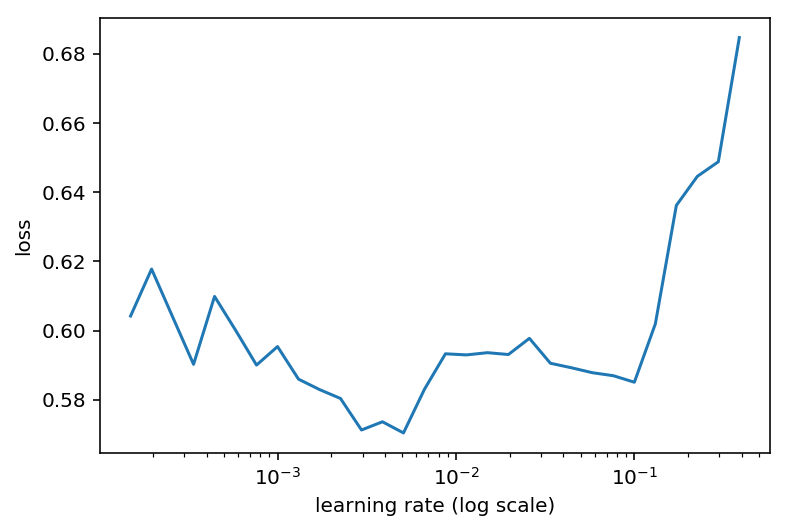

In [58]:
lrf = learn.lr_find()
learn.sched.plot()

In [59]:
lr = 3e-3

In [60]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch:   0, train_loss: 0.711616, val_loss: 0.570689, accuracy: 0.500000
epoch:   1, train_loss: 0.617983, val_loss: 0.546725, accuracy: 0.500000
epoch:   2, train_loss: 0.610180, val_loss: 0.467445, accuracy: 1.000000
epoch:   3, train_loss: 0.591091, val_loss: 0.485374, accuracy: 1.000000
epoch:   4, train_loss: 0.644294, val_loss: 0.573752, accuracy: 0.500000
epoch:   5, train_loss: 0.586180, val_loss: 0.534644, accuracy: 1.000000
epoch:   6, train_loss: 0.573675, val_loss: 0.557776, accuracy: 0.500000



In [61]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch:   0, train_loss: 0.580049, val_loss: 0.531921, accuracy: 1.000000
epoch:   1, train_loss: 0.556873, val_loss: 0.606347, accuracy: 1.000000
epoch:   2, train_loss: 0.546220, val_loss: 0.547647, accuracy: 0.500000
epoch:   3, train_loss: 0.571340, val_loss: 0.487536, accuracy: 1.000000
epoch:   4, train_loss: 0.580353, val_loss: 0.585373, accuracy: 1.000000
epoch:   5, train_loss: 0.573155, val_loss: 0.544759, accuracy: 0.500000
epoch:   6, train_loss: 0.553728, val_loss: 0.582847, accuracy: 0.500000



In [62]:
learn.unfreeze()
learn.data.bs = 6
lr = lr / (32/6) # learning rate originally 3e-3

In [63]:
lrs = np.array([lr/14, lr/7, lr])
# use lr/1e2 and lr/1e1 respectively if images would've been larger in size

In [64]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch:   0, train_loss: 0.777872, val_loss: 4.206906, accuracy: 0.500000
epoch:   1, train_loss: 0.627440, val_loss: 13.481349, accuracy: 0.000000
epoch:   2, train_loss: 0.568531, val_loss: 0.673095, accuracy: 0.500000
epoch:   3, train_loss: 0.495213, val_loss: 1.555458, accuracy: 0.500000
epoch:   4, train_loss: 0.543799, val_loss: 6571.040527, accuracy: 0.500000
epoch:   5, train_loss: 0.643674, val_loss: 1.070360, accuracy: 0.000000
epoch:   6, train_loss: 0.642574, val_loss: 0.615660, accuracy: 0.500000



In [65]:
1 / (32/6), (1/(32/6))/(6/32)

(0.1875, 1.0)

In [66]:
learn.freeze()
learn.data.bs=32
lr = lr / (6/32)

In [67]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch:   0, train_loss: 0.592825, val_loss: 0.582250, accuracy: 0.500000
epoch:   1, train_loss: 0.554472, val_loss: 0.616713, accuracy: 0.500000
epoch:   2, train_loss: 0.569836, val_loss: 0.571422, accuracy: 0.500000
epoch:   3, train_loss: 0.564584, val_loss: 0.654299, accuracy: 0.500000
epoch:   4, train_loss: 0.530406, val_loss: 0.507393, accuracy: 0.500000
epoch:   5, train_loss: 0.523236, val_loss: 0.571249, accuracy: 0.500000
epoch:   6, train_loss: 0.513759, val_loss: 0.545141, accuracy: 0.500000



In [68]:
learn.fit(lr/2, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch:   0, train_loss: 0.521997, val_loss: 0.512084, accuracy: 0.500000
epoch:   1, train_loss: 0.499135, val_loss: 0.640148, accuracy: 0.500000
epoch:   2, train_loss: 0.493229, val_loss: 0.597776, accuracy: 0.500000
epoch:   3, train_loss: 0.490864, val_loss: 0.593194, accuracy: 0.500000
epoch:   4, train_loss: 0.495848, val_loss: 0.538949, accuracy: 0.500000
epoch:   5, train_loss: 0.484356, val_loss: 0.515972, accuracy: 0.500000
epoch:   6, train_loss: 0.478068, val_loss: 0.518013, accuracy: 0.500000



## 3.1 Test Data

In [69]:
%%time
log_preds, y = learn.TTA(is_test=True)

CPU times: user 2min 50s, sys: 1min 7s, total: 3min 57s
Wall time: 3min 22s


In [70]:
ice_preds = np.mean(np.exp(log_preds), 0)

In [71]:
df = pd.DataFrame(ice_preds)
df.columns = data.classes

In [72]:
df.insert(0, 'id', [y.split('/')[-1].split('_')[-1].split('.')[0] for y in 
                    data.test_ds.fnames])

In [73]:
sub = df[['id', 'ice']]
sub.columns = ['id', 'is_iceberg']

In [74]:
sub.to_csv('data/subm/iceberg_sub_k-3_IRNv2.csv',index=False)

In [39]:
FileLink('data/subm/iceberg_sub_k-1.csv')

/home/wnixalo/iceberg/data/subm/iceberg_sub_k-1.csv

In [53]:
FileLink('data/subm/iceberg_sub_k-2_RN18.csv')

/home/wnixalo/iceberg/data/subm/iceberg_sub_k-2_RN18.csv

In [75]:
FileLink('data/subm/iceberg_sub_k-3_IRNv2.csv')

/home/wnixalo/iceberg/data/subm/iceberg_sub_k-3_IRNv2.csv